
 # Transformaciones Generales de Imágenes

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# %%

import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
figsize = (10,15)

def _plot(img):
    plt.figure(figsize=figsize)
    plt.imshow(img)

def leer_imagen(ruta):
    img = cv2.imread(ruta, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


 ## Parámetros


 Podemos especificar la imagen ajustando su `ruta_imagen`

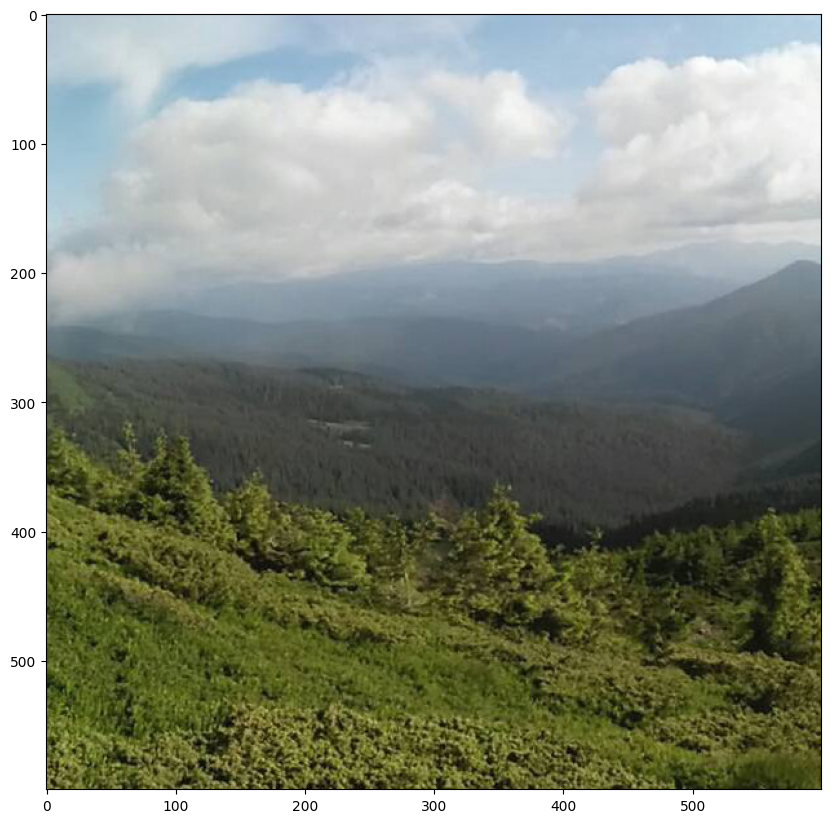

In [3]:
# %%

ruta_imagen = '/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-02/landscape.jpg'
img = leer_imagen(ruta_imagen)
_plot(img)



 Aquí definimos cómo se transformaron tres puntos no colineales para identificar la matriz de transformación para toda la imagen.

In [4]:
# %%

r,c,_ = img.shape
tamano_destino = (r,c)
offset = 50
puntos_originales = np.float32([[0,0],[r,0],[0,c]])
puntos_transformados = np.float32([[offset,0],[r,offset],[0,c-offset]])


 ## Nuestra Implementación





 En una Transformación Afín, cada punto $(x,y)$ se transforma en un punto $(x',y') = (a_1*x + b_1*y + c_1, a_2*x + b_2*y + c_2)$. En forma matricial, esto se expresa como:

 $$ \begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a_1 & b_1 \\ a_2 & b_2 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} c_1 \\ c_2 \end{bmatrix},$$
 o también como:
 $$ \begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a_1 & b_1 & c_1 \\ a_2 & b_2 & c_2 \end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = M \cdot p$$

 Donde M es nuestra matriz de transformación. Como esta matriz tiene 6 parámetros desconocidos, necesitamos al menos 3 puntos transformados para determinarla, lo cual se hace en la función `getAffineTransform`.

In [5]:
# %%

def getAffineTransform(puntos_originales, puntos_transformados):
    p = []
    for x,y in puntos_originales:
        p.append((x,y,1))

    return np.linalg.solve(p, puntos_transformados).T


 Utilizamos estas funciones auxiliares para mantener la notación consistente en el algoritmo, es decir, cuando indexamos `img[a,b]`, `a` representa las coordenadas horizontales, y `b`, las verticales. OpenCV requiere los puntos en formato `(horizontal, vertical)`, mientras que el acceso directo debe ser `(vertical, horizontal)`.

In [10]:
# %%

def a_matriz(img):
    H,V,C = img.shape
    mtr = np.zeros((V,H,C), dtype=int)
    for i in range(img.shape[0]):
        mtr[:,i] = img[i]

    return mtr

def a_imagen(mtr):
    V,H,C = mtr.shape
    img = np.zeros((H,V,C), dtype=int)
    for i in range(mtr.shape[0]):
        img[:,i] = mtr[i]

    return img


 Una vez obtenida la matriz de transformación M, queremos saber cómo se verá la imagen completa transformada, es decir, queremos construir una imagen donde cada píxel en la ubicación $\begin{bmatrix} x' \\ y' \end{bmatrix}$ sea igual a $M \cdot \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$. Esto se logra con la función `warpAffine`. Además de los parámetros `img` (imagen original), `M` (matriz de transformación), también tenemos `dsize`, que indica el tamaño de la imagen de salida.

In [11]:
# %%

def warpAffine(img, M, dsize):
    mtr = a_matriz(img)
    R,C = dsize
    dst = np.zeros((R,C,mtr.shape[2]))
    for i in range(mtr.shape[0]):
        for j in range(mtr.shape[1]):
            i_dst,j_dst = np.dot(M, [i,j,1]).astype(int)
            if i_dst >= 0 and i_dst < R:
                if j_dst >= 0 and j_dst < C:
                    dst[i_dst,j_dst] = mtr[i,j]

    return a_imagen(dst)

In [12]:
# %%

%%time
M = getAffineTransform(puntos_originales,puntos_transformados)
print(M)

[[ 0.91666667 -0.08333333 50.        ]
 [ 0.08333333  0.91666667  0.        ]]
CPU times: user 2.89 ms, sys: 3.54 ms, total: 6.42 ms
Wall time: 5.84 ms


CPU times: user 2.05 s, sys: 6.88 ms, total: 2.05 s
Wall time: 2.25 s


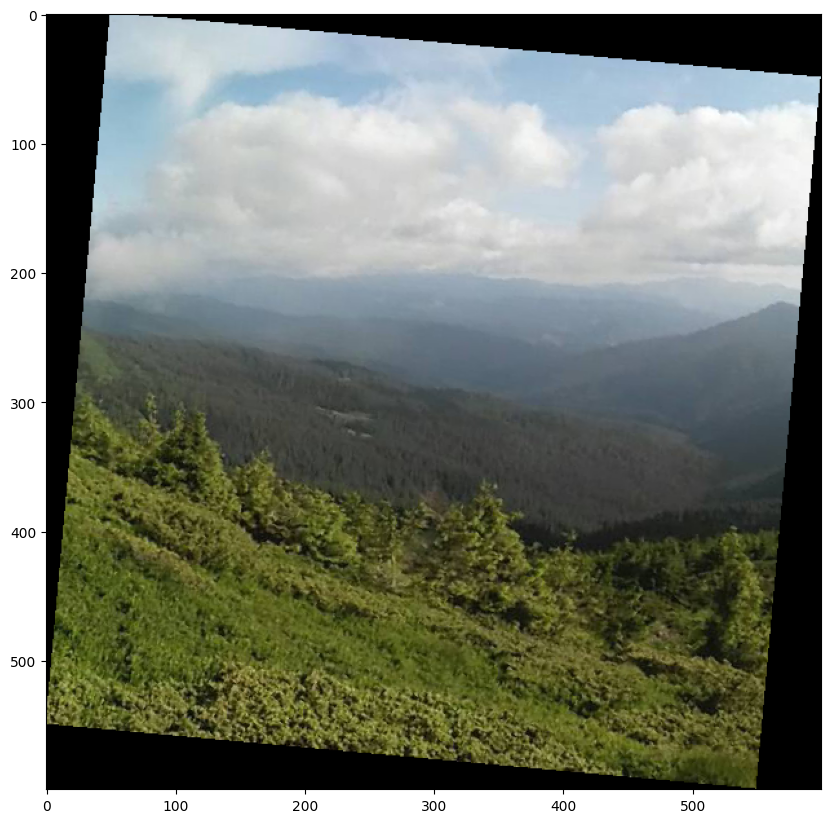

In [13]:
# %%

%%time
dst = warpAffine(img, M, tamano_destino)
_plot(dst)


 ### Implementación en OpenCV


 Para validar nuestra implementación, comparamos los resultados con las funciones [getAffineTransform](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=getaffinetransform#getaffinetransform) y [warpAffine](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=getaffinetransform#warpaffine) de OpenCV, las cuales muestran resultados idénticos.

In [14]:
# %%

%%time
M_cv = cv2.getAffineTransform(puntos_originales,puntos_transformados)
print(M_cv)

[[ 0.91666667 -0.08333333 50.        ]
 [ 0.08333333  0.91666667  0.        ]]
CPU times: user 2.67 ms, sys: 82 µs, total: 2.75 ms
Wall time: 2.98 ms


CPU times: user 22.4 ms, sys: 0 ns, total: 22.4 ms
Wall time: 29.5 ms


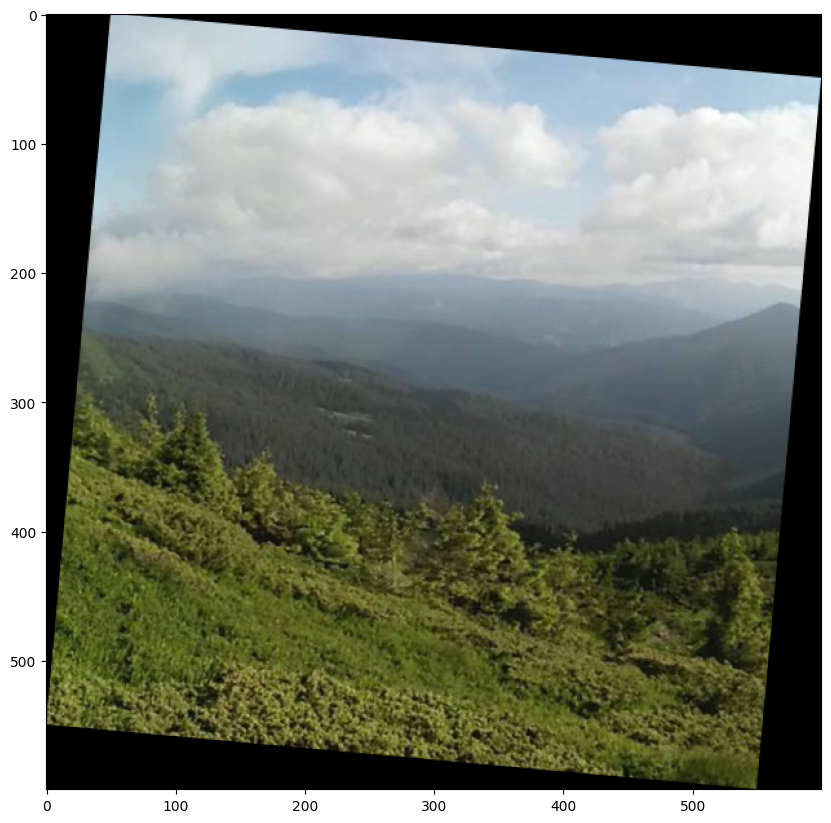

In [15]:
# %%

%%time
dst_cv = cv2.warpAffine(img, M_cv, tamano_destino)
_plot(dst_cv)


 ## Otras Transformaciones con OpenCV


 ### Rotación

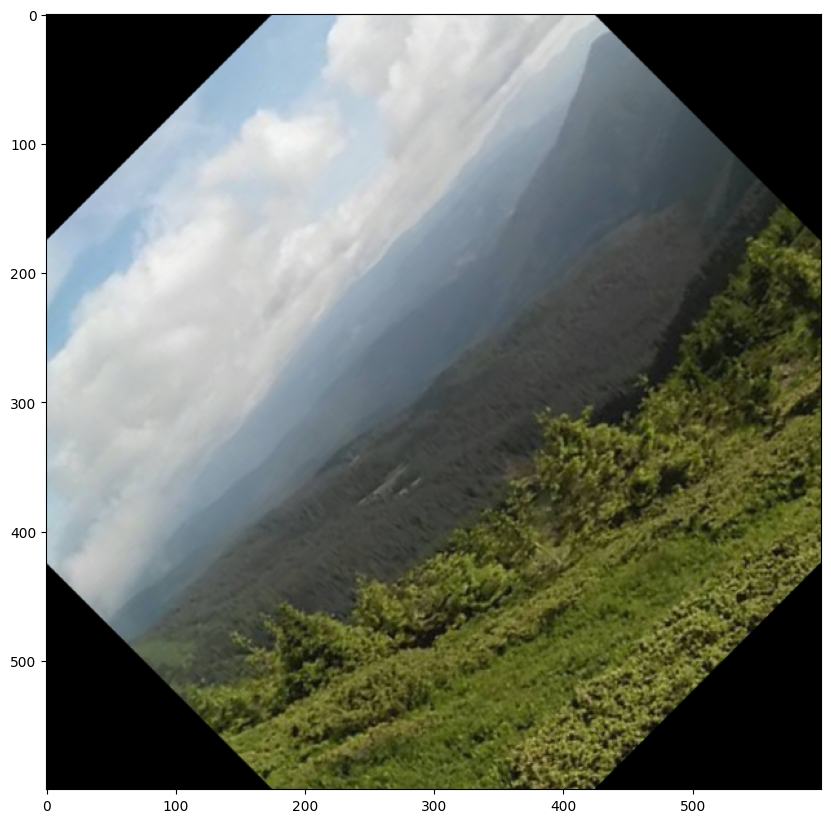

In [16]:
# %%

angulo = 45
centro = (c // 2, r // 2)
M_rotacion = cv2.getRotationMatrix2D(centro, angulo, 1.0)
img_rotada = cv2.warpAffine(img, M_rotacion, (c, r))
_plot(img_rotada)


 ### Escalado

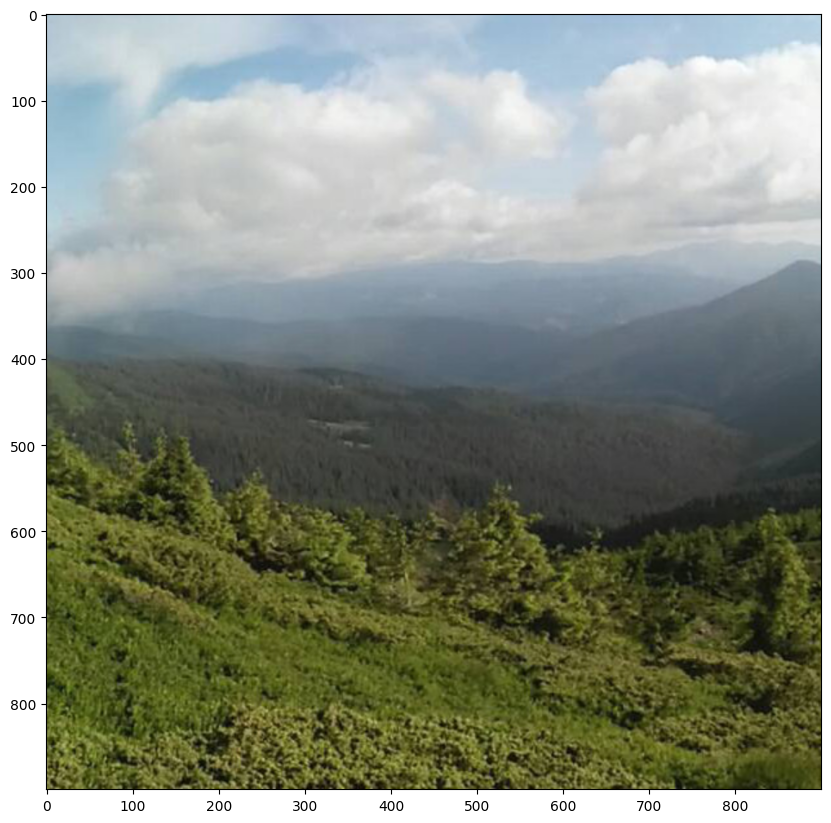

In [17]:
# %%

factor_escala = 1.5
img_escalada = cv2.resize(img, None, fx=factor_escala, fy=factor_escala, interpolation=cv2.INTER_LINEAR)
_plot(img_escalada)


 ### Traslación

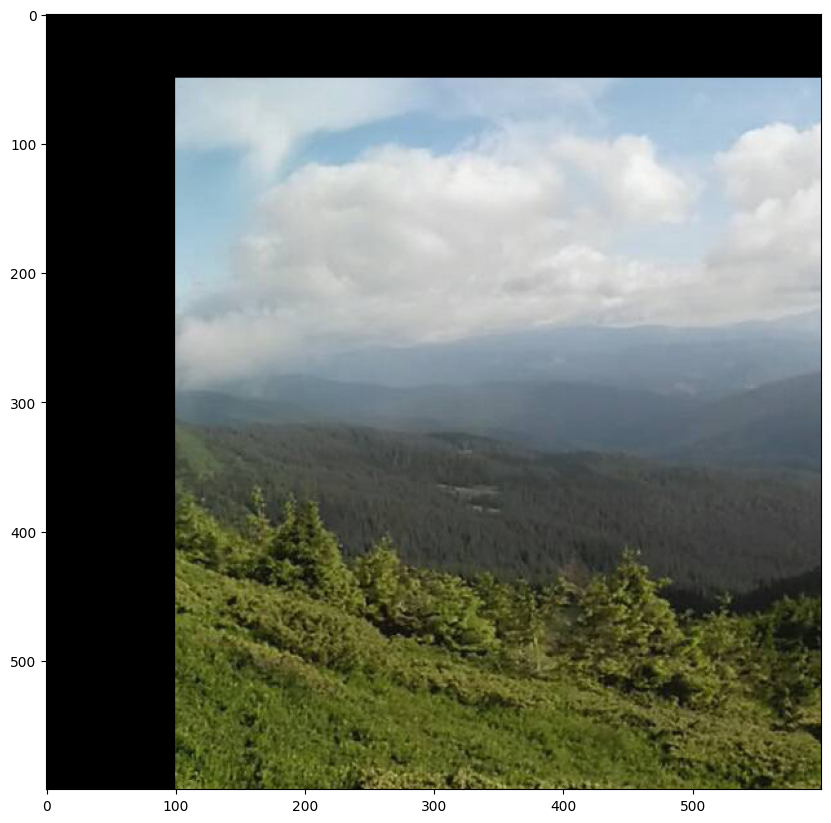

In [18]:
# %%

desplazamiento = np.float32([[1, 0, 100], [0, 1, 50]])
img_trasladada = cv2.warpAffine(img, desplazamiento, (c, r))
_plot(img_trasladada)


 ### Transformación de Perspectiva

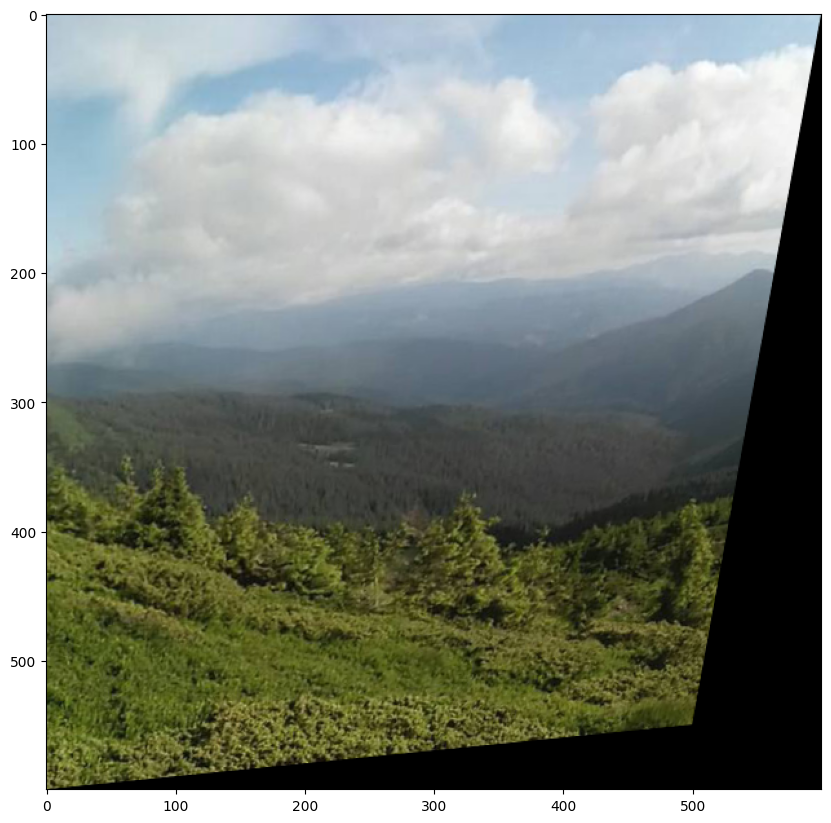

In [19]:
# %%

puntos_destino_perspectiva = np.float32([[0,0], [c,0], [0,r], [c-100, r-50]])
M_perspectiva = cv2.getPerspectiveTransform(np.float32([[0,0],[c,0],[0,r],[c,r]]), puntos_destino_perspectiva)
img_perspectiva = cv2.warpPerspective(img, M_perspectiva, (c, r))
_plot(img_perspectiva)




 # Interpolación Bilineal
 - Cuando ampliamos una imagen y el factor de ampliación es grande, el método de interpolación de vecinos más cercanos puede producir un efecto de mosaico o un efecto de escalón en los bordes de la imagen. La interpolación bilineal es una técnica que ayuda a reducir estos problemas.
 - El término "bilineal" se refiere a la característica de una línea recta, como la ecuación de una línea. Cuando conocemos los valores de dos píxeles, podemos imaginar una línea entre ellos y calcular los valores de los píxeles en esta línea mediante interpolación.
 - Consulta un blog o documentación adicional para detalles de las fórmulas utilizadas.


 ### Constantes de opción de método de interpolación


 | Constante de opción | Valor | Descripción |
 |---------------------|-------|-------------|
 |cv2.INTER_NEAREST    | 0     | Interpolación de vecino más cercano|
 |cv2.INTER_LINEAR     | 1     | Interpolación bilineal (valor por defecto)|
 |cv2.INTER_CUBIC      | 2     | Interpolación bicúbica - usa una vecindad de 4x4 píxeles|
 |cv2.INTER_AREA       | 3     | Remuestreo en función de la relación de área de píxeles|
 |cv2.INTER_LANCZOS4   | 4     | Interpolación de Lanczos - usa una vecindad de 8x8 píxeles|

In [20]:
# %%

import numpy as np, cv2


 ## Función de Escalado utilizando el Método de Vecino Más Cercano

In [21]:
# %%

def escalado_vecino_mas_cercano(img, size):                       # Función de cambio de tamaño
    dst = np.zeros(size[::-1], img.dtype)                         # Crear matriz con tamaño y tipo especificados
    ratioY, ratioX = np.divide(size[::-1], img.shape[:2])         # Calcular proporciones de cambio de tamaño
    i = np.arange(0, size[1], 1)
    j = np.arange(0, size[0], 1)
    i, j = np.meshgrid(i, j)
    y, x = np.int32(i / ratioY), np.int32(j / ratioX)
    dst[i,j] = img[y,x]
    return dst


 ## Función para Interpolación Bilineal en un solo píxel

In [22]:
# %%

def valor_bilinear(img, pt):                          # Realiza interpolación bilineal en un solo píxel
    x, y = np.int32(pt)
    if x >= img.shape[1]-1: x = x -1 # Asegurarse de no salir del rango de la imagen
    if y >= img.shape[0]-1: y = y - 1

    # Extraer los 4 píxeles adyacentes
    P1, P3, P2, P4 = np.float32(img[y:y+2,x:x+2].flatten())

    # Calcular los factores de distancia
    alpha, beta = pt[1] - y,  pt[0] - x
    M1 = P1 + alpha * (P3 - P1)                       # Interpolación en una dirección
    M2 = P2 + alpha * (P4 - P2)
    P  = M1 + beta  * (M2 - M1)                       # Interpolación en la otra dirección
    return  np.clip(P, 0, 255)                        # Saturación del valor del píxel y retorno


 ## Función de Escalado utilizando Interpolación Bilineal

In [23]:
# %%

def escalado_bilinear(img, size):                         # Interpolación bilineal
    ratioY, ratioX = np.divide(size[::-1], img.shape[:2]) # Calcular proporciones de cambio de tamaño

    dst = [[ valor_bilinear(img, (j/ratioX, i/ratioY))    # Generar lista con bucle for
             for j in range(size[0])]
           for i in range(size[1])]
    return np.array(dst, img.dtype)


 ## Lectura y Escalado de Imagen

In [25]:
# %%
ruta_int="/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-02/interpolation.jpg"
imagen = cv2.imread(ruta_int, cv2.IMREAD_GRAYSCALE)
if imagen is None: raise Exception("Error al leer el archivo de imagen")


 ### Aplicación de Métodos de Escalado

In [26]:
# %%

tamano = (350, 400)
dst1 = escalado_bilinear(imagen, tamano)                # Cambio de tamaño con interpolación bilineal
dst2 = escalado_vecino_mas_cercano(imagen, tamano)      # Cambio de tamaño con vecino más cercano
dst3 = cv2.resize(imagen, tamano, 0, 0, cv2.INTER_LINEAR)  # Uso de la función de OpenCV
dst4 = cv2.resize(imagen, tamano, 0, 0, cv2.INTER_NEAREST)


 ## Mostrar Resultados

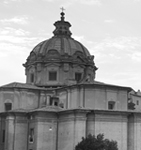

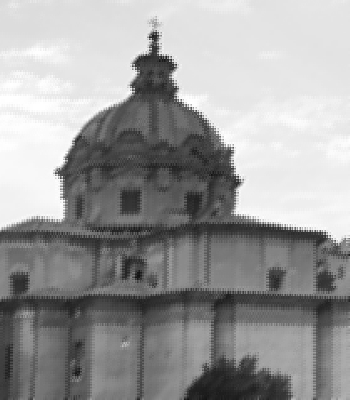

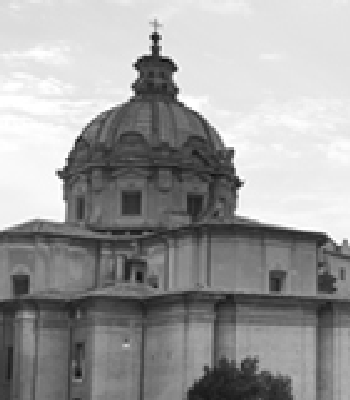

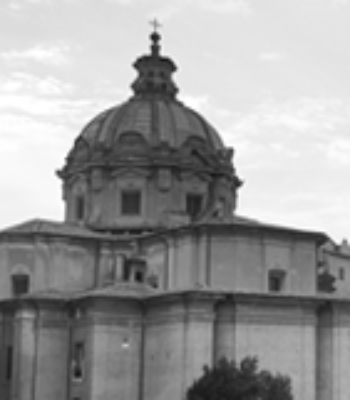

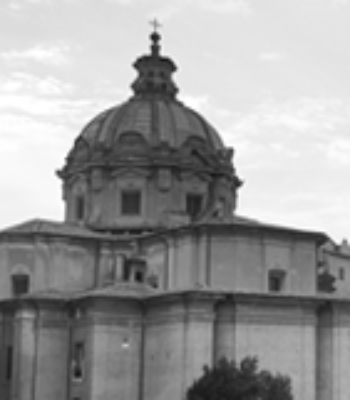

-1

In [29]:
# %%
from google.colab.patches import cv2_imshow
cv2_imshow( imagen)
cv2_imshow( dst1)
cv2_imshow(dst2)
cv2_imshow(dst3)
cv2_imshow(dst4)
cv2.waitKey(0)


 ## Transformaciones Geométricas de Imágenes

 OpenCV proporciona varias funciones para realizar transformaciones geométricas en imágenes, como escalado, traslación, rotación, transformaciones afines y homográficas. A continuación, exploraremos cada una de ellas.

In [30]:
# %%

import numpy as np
import cv2  # Librería OpenCV-Python
%matplotlib inline
import matplotlib.pyplot as plt





 ### Escalado

 En el escalado, cambiamos el tamaño de la imagen aumentando o disminuyendo su resolución. Aquí utilizamos el método `cv2.resize` para duplicar el tamaño de la imagen original.

 - `interpolation=cv2.INTER_CUBIC`: Utilizamos la interpolación bicúbica, que considera una vecindad de 4x4 píxeles para producir una imagen más suave.

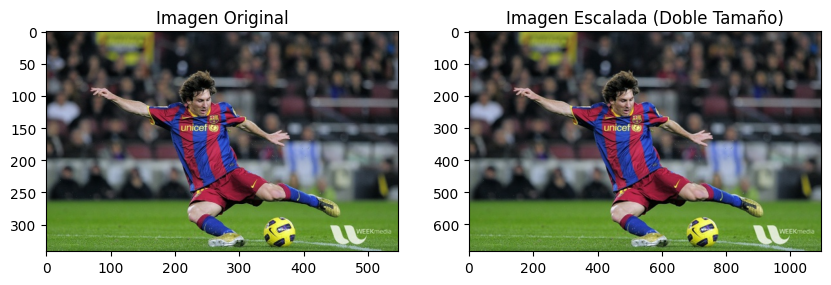

In [31]:
# %%
img_messi="/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-02/messi.jpg"
img = cv2.imread(img_messi)
height, width = img.shape[:2]
res = cv2.resize(img, (2*width, 2*height), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Imagen Escalada (Doble Tamaño)")
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))


 ### Traslación

 La traslación desplaza la imagen en la dirección especificada. Esto se realiza utilizando la función `cv2.warpAffine`, que aplica una transformación afín.

 - `M = np.float32([[1, 0, dx], [0, 1, dy]])`: La matriz de transformación para la traslación, donde `dx` y `dy` son desplazamientos en las direcciones x e y, respectivamente.
 - `cv2.warpAffine`: Aplica la transformación afín a la imagen con la matriz `M`.

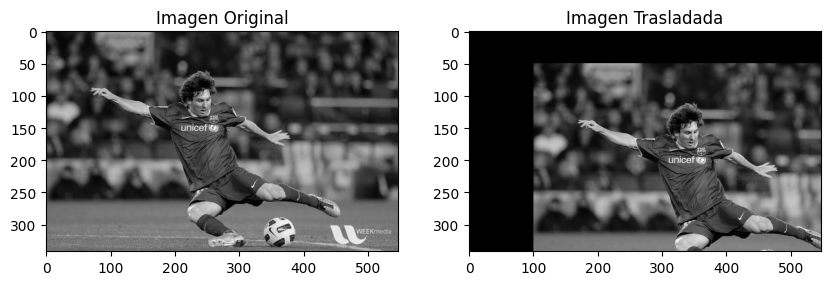

In [32]:
# %%

img = cv2.imread(img_messi, cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape

# Matriz de traslación (dx=100, dy=50)
M = np.float32([[1, 0, 100], [0, 1, 50]])
dst = cv2.warpAffine(img, M, (cols, rows))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Imagen Trasladada")
plt.imshow(dst, cmap='gray')


 ### Rotación

 La rotación gira la imagen en un ángulo determinado en torno a un punto específico.

 - `cv2.getRotationMatrix2D`: Calcula la matriz de transformación para la rotación, especificando el centro, el ángulo, y el factor de escala.
 - `cv2.warpAffine`: Aplica la matriz de rotación a la imagen.

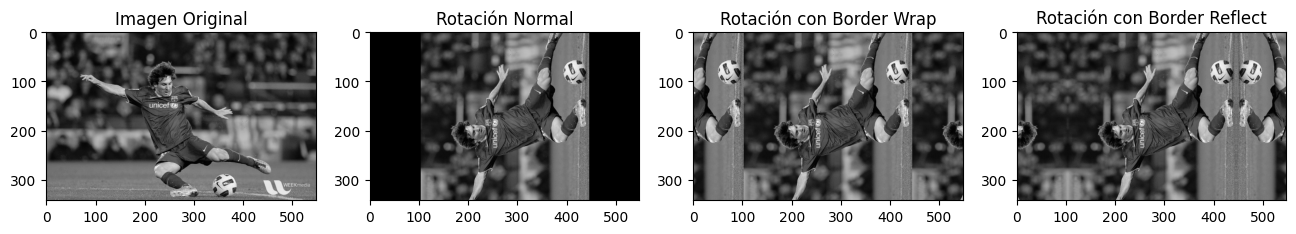

In [33]:
# %%

img = cv2.imread(img_messi, cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape

# Matriz de rotación para 90 grados alrededor del centro de la imagen
M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
dst1 = cv2.warpAffine(img, M, (cols, rows))
dst2 = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_WRAP)
dst3 = cv2.warpAffine(img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)

plt.figure(figsize=(16,3))
plt.subplot(1, 4, 1)
plt.title("Imagen Original")
plt.imshow(img, cmap='gray')
plt.subplot(1, 4, 2)
plt.title("Rotación Normal")
plt.imshow(dst1, cmap='gray')
plt.subplot(1, 4, 3)
plt.title("Rotación con Border Wrap")
plt.imshow(dst2, cmap='gray')
plt.subplot(1, 4, 4)
plt.title("Rotación con Border Reflect")
plt.imshow(dst3, cmap='gray')


 ### Transformación Afín

 En una transformación afín, las líneas rectas permanecen rectas después de la transformación. Esto se logra utilizando tres pares de puntos de correspondencia.

 - `cv2.getAffineTransform`: Calcula la matriz de transformación afín a partir de dos conjuntos de tres puntos.
 - `cv2.warpAffine`: Aplica la matriz de transformación a la imagen.

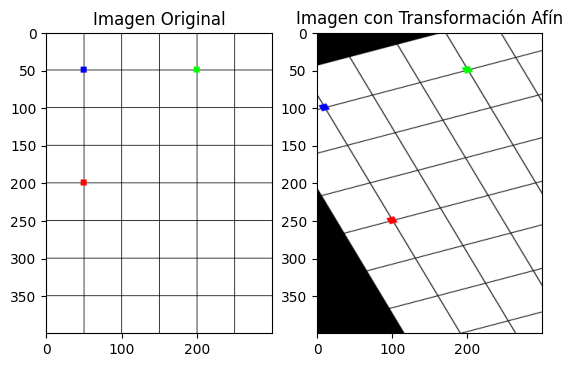

In [35]:
# %%
ruta_drawing="/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-02/drawing.png"
img = cv2.imread(ruta_drawing)
rows, cols, ch = img.shape

# Puntos para la transformación afín
pts1 = np.float32([[50, 50], [200, 50], [50, 200]])
pts2 = np.float32([[10, 100], [200, 50], [100, 250]])

M = cv2.getAffineTransform(pts1, pts2)
dst = cv2.warpAffine(img, M, (cols, rows))

plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Imagen con Transformación Afín")
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))


 ### Transformación Homográfica (Perspectiva)

 La transformación homográfica permite cambiar la perspectiva de la imagen. Para calcular la matriz de transformación, necesitamos cuatro puntos en cada imagen.

 - `cv2.getPerspectiveTransform`: Calcula la matriz de transformación homográfica a partir de dos conjuntos de cuatro puntos.
 - `cv2.warpPerspective`: Aplica la matriz de transformación homográfica a la imagen, cambiando su perspectiva.

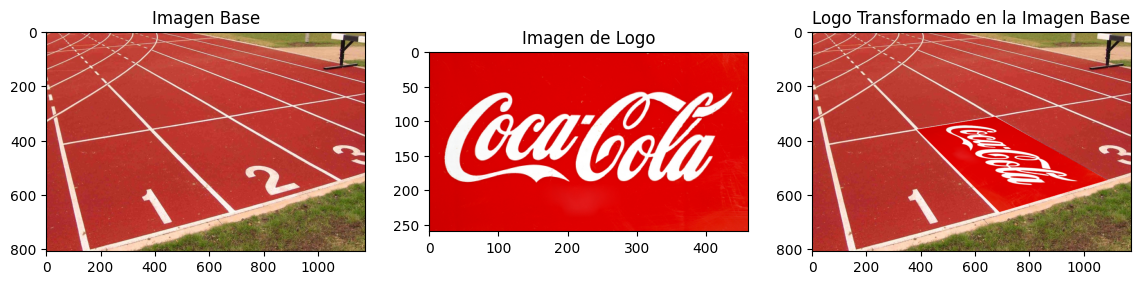

In [36]:
# %%

img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-02/track.jpg')
img2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/cursoProcesamientoImagenes_opencv/Clases-Notebooks/images-02/logo.jpg')
rows1, cols1, ch1 = img1.shape
rows2, cols2, ch2 = img2.shape

# Puntos de correspondencia en ambas imágenes
pts1 = np.float32([(0, 0), (cols2-1, 0), (cols2-1, rows2-1), (0, rows2-1)])
pts2 = np.float32([(671, 314), (1084, 546), (689, 663), (386, 361)])

M = cv2.getPerspectiveTransform(pts1, pts2)
img3 = np.copy(img1)
cv2.warpPerspective(img2, M, (cols1, rows1), img3, borderMode=cv2.BORDER_TRANSPARENT)

plt.figure(figsize=(14,3))
plt.subplot(1, 3, 1)
plt.title("Imagen Base")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Imagen de Logo")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Logo Transformado en la Imagen Base")
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))